# Praca domowa nr 9
_Piotr Halama_

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV

## Dataset

In [10]:
data = pd.read_csv('../../../driftDatasets/artificial/hyperplane/rotatingHyperplane.data', sep=' ', header=None)
labels = pd.read_csv('../../../driftDatasets/artificial/hyperplane/rotatingHyperplane.labels', sep=' ', header=None)

In [12]:
data.head(5)

,0,1,2,3,4,5,6,7,8,9
0,0.397174,0.347518,0.294057,0.506484,0.115967,0.770536,0.659893,0.156747,0.378202,0.139763
1,0.275030,0.075388,0.610592,0.954931,0.274069,0.190202,0.001299,0.683527,0.486260,0.487515
2,0.233156,0.889909,0.038327,0.592379,0.655174,0.119839,0.652477,0.984323,0.206738,0.374650
3,0.277937,0.340915,0.265790,0.116670,0.136830,0.546089,0.494619,0.015384,0.358995,0.242478
4,0.254909,0.777916,0.225022,0.983103,0.803619,0.836315,0.163104,0.637497,0.008760,0.631190


In [13]:
data.shape

(200000, 10)

### Splitting the dataset

In [27]:
data_1 = data.iloc[:20000]
labels_1 = labels.iloc[:20000, 0]

data_2 = data.iloc[-20000:]
labels_2 = labels.iloc[-20000:, 0]

## Fitting a model

In [28]:
clf_1 = LogisticRegressionCV(cv=5)
clf_1.fit(data_1, labels_1)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [29]:
clf_2 = LogisticRegressionCV(cv=5)
clf_2.fit(data_2, labels_2)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

## Data distribution

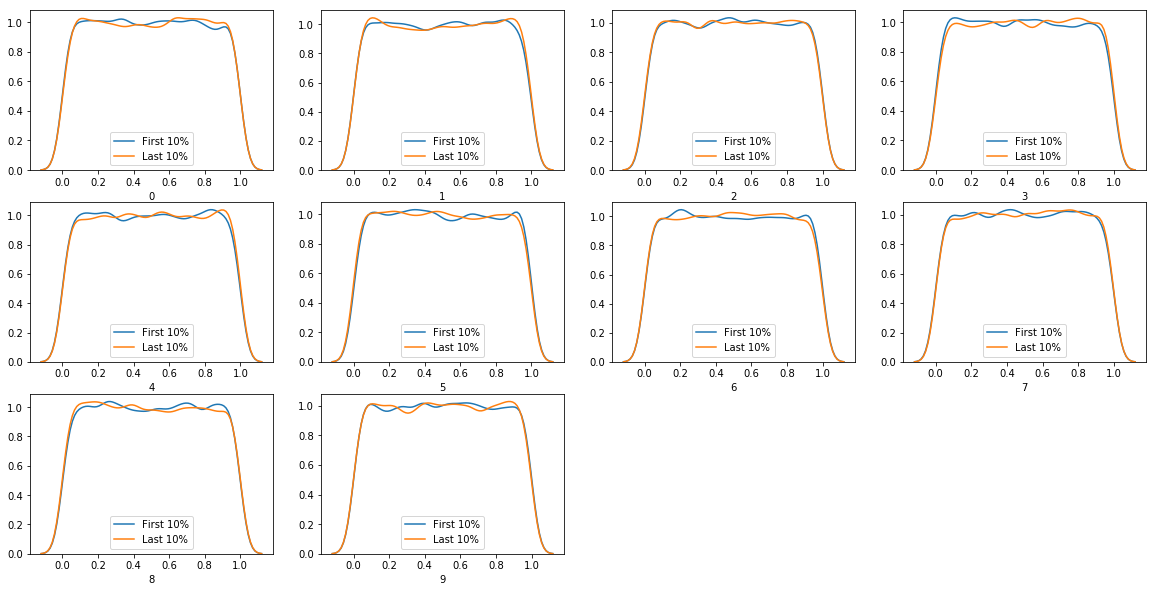

In [52]:
fig = plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(3, 4, i+1)
    sns.distplot(data_1.iloc[:, i], bins=100, hist=False, label='First 10%')
    sns.distplot(data_2.iloc[:, i], bins=100, hist=False, label='Last 10%')

plt.show()

## Intersection distance

In [63]:
def intersection_distance(P, Q, bins=100):
    Pp = np.histogram(P, bins=bins)[0] / np.float(P.shape[0])
    Qp = np.histogram(Q, bins=bins)[0] / np.float(Q.shape[0])
    
    return 1 - np.sum(np.minimum(Pp, Qp))

### Intersection distance for data

In [65]:
distances = [
    intersection_distance(data_1.iloc[:, i], data_2.iloc[:, i])
    for i in range(10)   
]

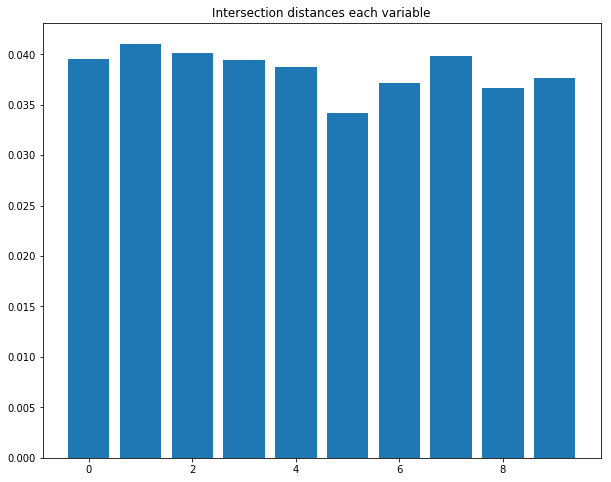

In [70]:
plt.figure(figsize=(10, 8))

plt.bar(range(10), distances)
plt.title("Intersection distances each variable")

plt.show()

### Intersection distance for residuals

In [111]:
residual_1_1 = labels_1 - clf_1.predict_proba(data_1)[:, 1]
residual_1_2 = labels_2 - clf_1.predict_proba(data_2)[:, 1]
residual_2_1 = labels_1 - clf_2.predict_proba(data_1)[:, 1]
residual_2_2 = labels_2 - clf_2.predict_proba(data_2)[:, 1]

In [108]:
intersection_distance(residual_1_1, residual_1_2)

0.2508

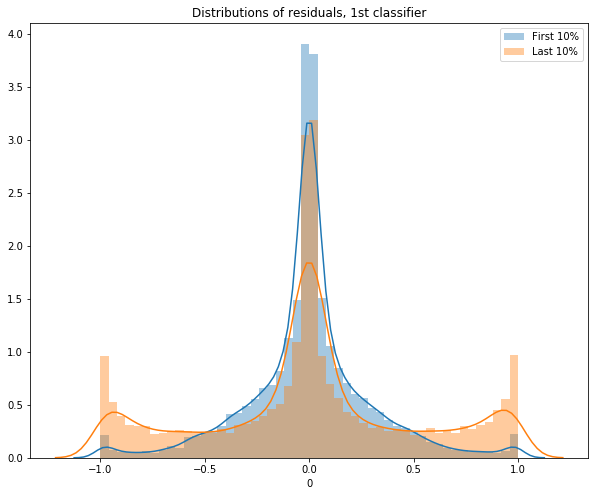

In [114]:
plt.figure(figsize=(10, 8))

sns.distplot(residual_1_1, label="First 10%")
sns.distplot(residual_1_2, label="Last 10%")

plt.title("Distributions of residuals, 1st classifier")
plt.legend()
plt.show()

In [112]:
intersection_distance(residual_2_1, residual_2_2)

0.249

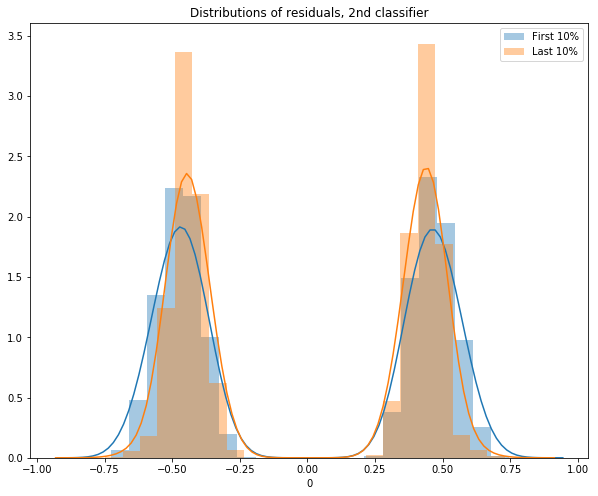

In [115]:
plt.figure(figsize=(10, 8))

sns.distplot(residual_2_1, label="First 10%")
sns.distplot(residual_2_2, label="Last 10%")

plt.title("Distributions of residuals, 2nd classifier")
plt.legend()
plt.show()

## PDP plot difference

In [102]:
def pdp(model, X, var, n_samples=100):
    x_min = 0.0
    x_max = 1.0
    space = np.linspace(x_min, x_max, n_samples)
    
    responses = list()
    
    for x_subst in space:
        X_sub = X.copy()
        X_sub[var] = x_subst
        
        res = np.mean(model.predict(X_sub))
        responses.append(res)
    
    return np.array(responses), space

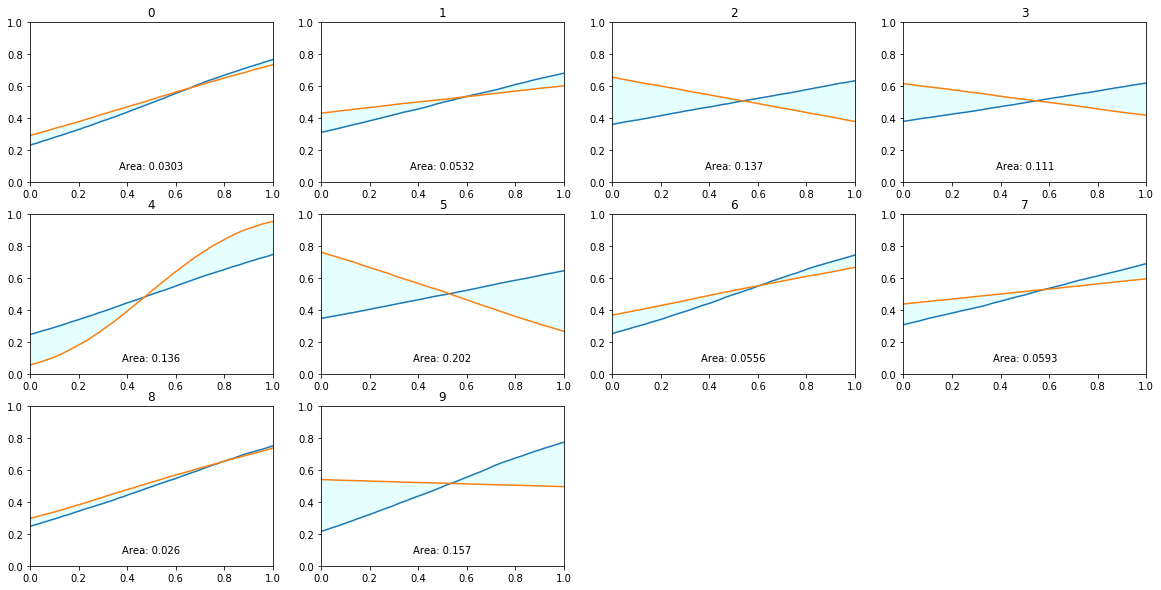

In [118]:
fig = plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.axis([0, 1, 0, 1])
    pdp_1, x_1 = pdp(clf_1, data_1, i)
    pdp_2, x_2 = pdp(clf_2, data_2, i)
    area = np.trapz(np.abs(pdp_1 - pdp_2), x_1)
    plt.plot(x_1, pdp_1, label='First 10%')
    plt.plot(x_2, pdp_2, label='Last 10%')
    plt.fill_between(x_1, pdp_1, pdp_2, color='cyan', alpha=0.1)
    plt.text(0.5, 0.1, f'Area: {area:.3}', horizontalalignment='center', verticalalignment='center')
    plt.title(i)

plt.show()

## Conclusion

* Distribution of every variable in both sets looks roughly the same. The intersection distance of each variable between both sets is similarly small.
* Distribution of residuals in 1st classifier on last 10% data shows significantly more residuals near -1 and 1 than for data from first 10%.
* Distribution of residuals in 2nd classifier shows two bimodal distributions. Distribution on first 10% of data is slighty more offset from center of the plot.
* Partial dependency plots show clearly, that most of the variables (no. 2, 3, 4, 5, 9) induce reverse response of the model.
* To sum up, while looking only on distributions of variables themselves didn't show concept drift, the phenomenon is obviously visible when looking at distributions of residuals or PDPs.